In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation
from skimage import color
from skimage import exposure


from scipy import ndimage as ndi

## Input and preprocessing

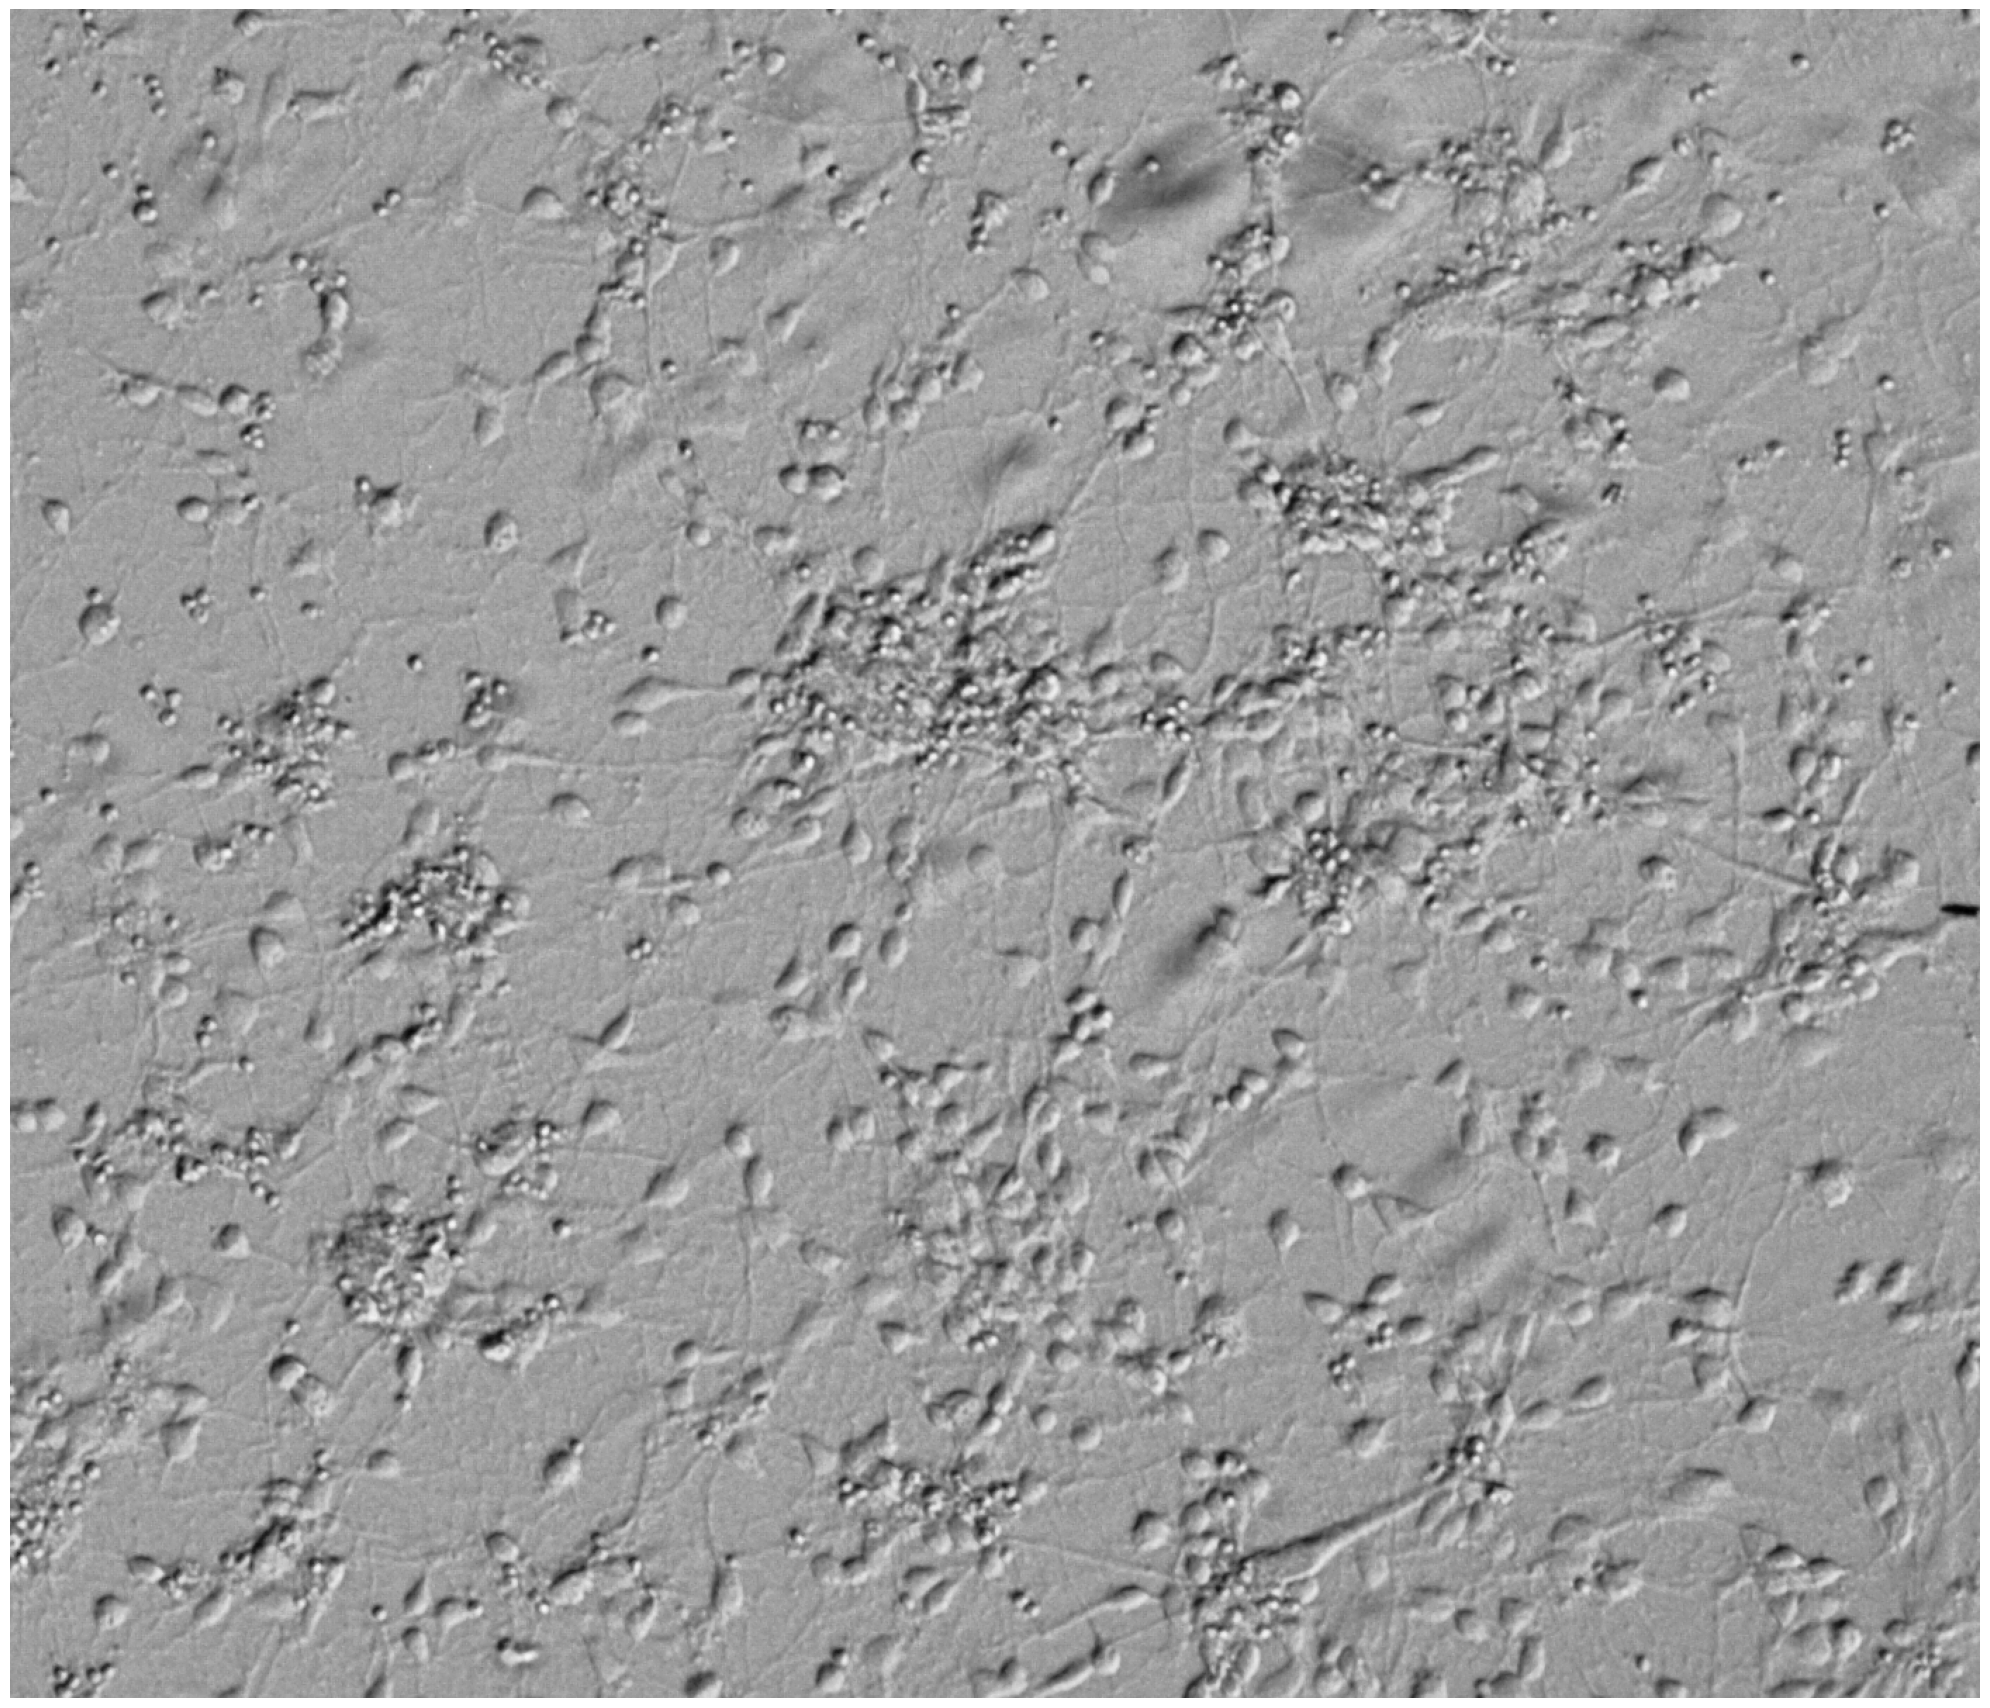

In [118]:
img_raw = io.imread('data/0135.tif')

img_grey = color.rgb2gray(img_raw)  # https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html
img_grey = img_grey[:,:-200]  # scale bar crop
img_filt = exposure.adjust_gamma(img_grey, 1.5)  # contrast adjustment

plt.figure(figsize=(20,20))
plt.imshow(img_filt*-1, cmap='Greys')
plt.axis('off')
plt.tight_layout()
plt.show()

## Cell mask

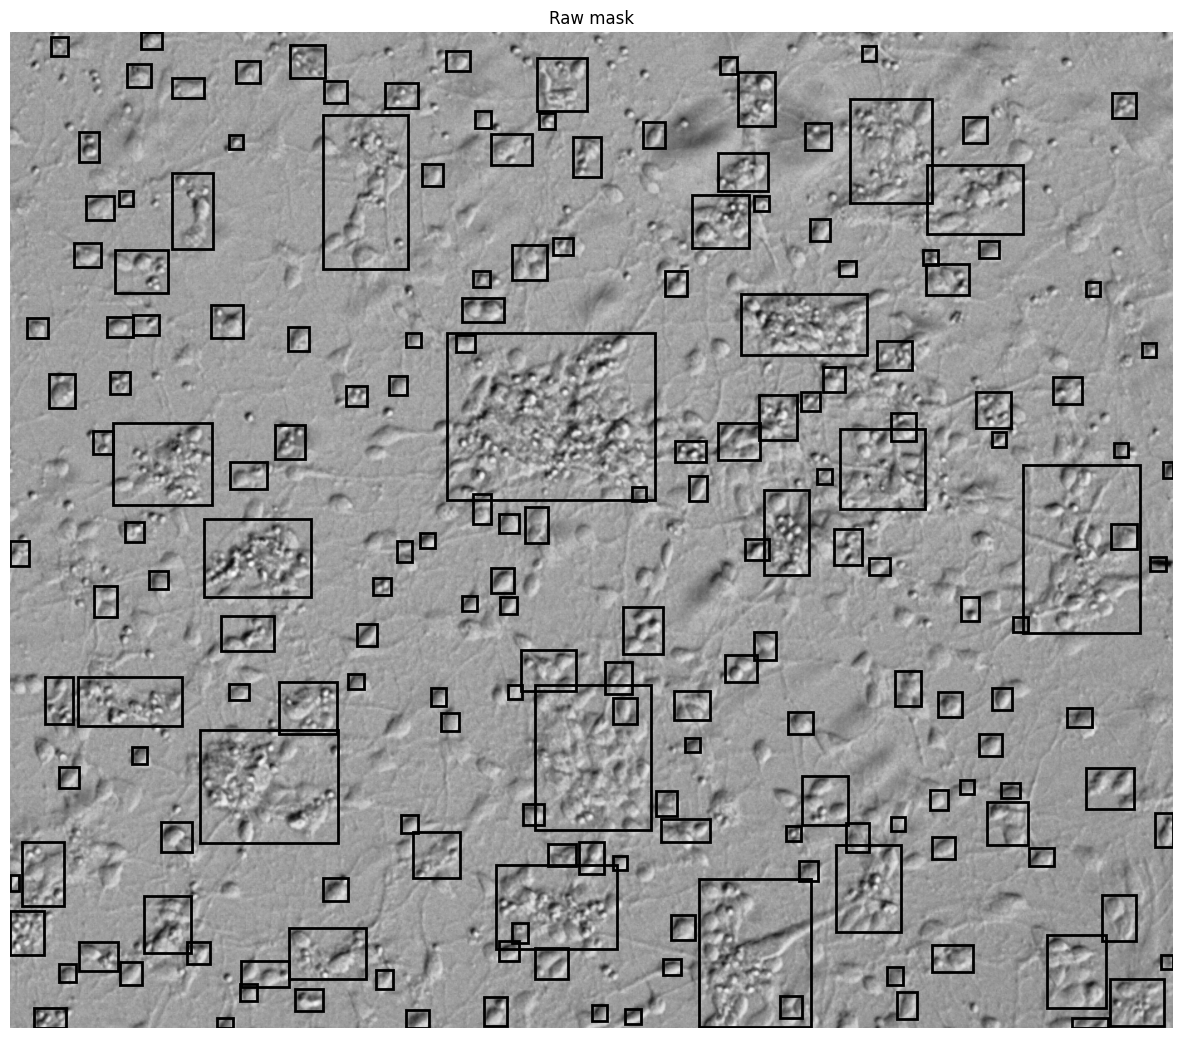

In [121]:
img_det = filters.rank.gradient(img_filt, morphology.disk(5))  # https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_marked_watershed.html#sphx-glr-auto-examples-segmentation-plot-marked-watershed-py

# cells masking by gradient image
mask_th = filters.threshold_sauvola(img_det, window_size=501, k=0.005, r=0.75)  # https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_niblack_sauvola.html
mask = img_det > mask_th
mask = ndi.binary_fill_holes(mask)

# small debris filtering
mask = morphology.erosion(mask, footprint=morphology.disk(10))
mask = morphology.dilation(mask, footprint=morphology.disk(8))

labels, labels_num = ndi.label(mask)
mask_props = measure.regionprops(labels)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_filt*-1, cmap='Greys')

for region in mask_props:
    # if region.label == 3:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='k', linewidth=2)
    ax.add_patch(rect)
    # ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=20)

# plt.imshow(ma.masked_where(~mask, labels), alpha=.9)
plt.title('Raw mask')
plt.axis('off')
plt.show()

## Mask elements sorting

### Simple sorting by size

In [122]:
sphere_mask = np.zeros_like(mask)  # neurospheres mask
cluster_mask = np.zeros_like(mask)      # small somas clusters mask
cell_mask = np.zeros_like(mask)    # individual somas mask

sphere_size_th = 120.0  # is this 50 um in px?
cluster_size_th = 90.0  # is this 50 um in px?

for region in mask_props: 
    if region.axis_major_length > sphere_size_th:
        sphere_mask[labels == region.label] = region.label
    elif region.axis_major_length > cluster_size_th:
        cluster_mask[labels == region.label] = region.label
    else:
        cell_mask[labels == region.label] = region.label

sphere_mask, sphere_num = ndi.label(sphere_mask) 
cluster_mask, cluster_num = ndi.label(cluster_mask) 
cell_mask, cell_num = ndi.label(cell_mask) 

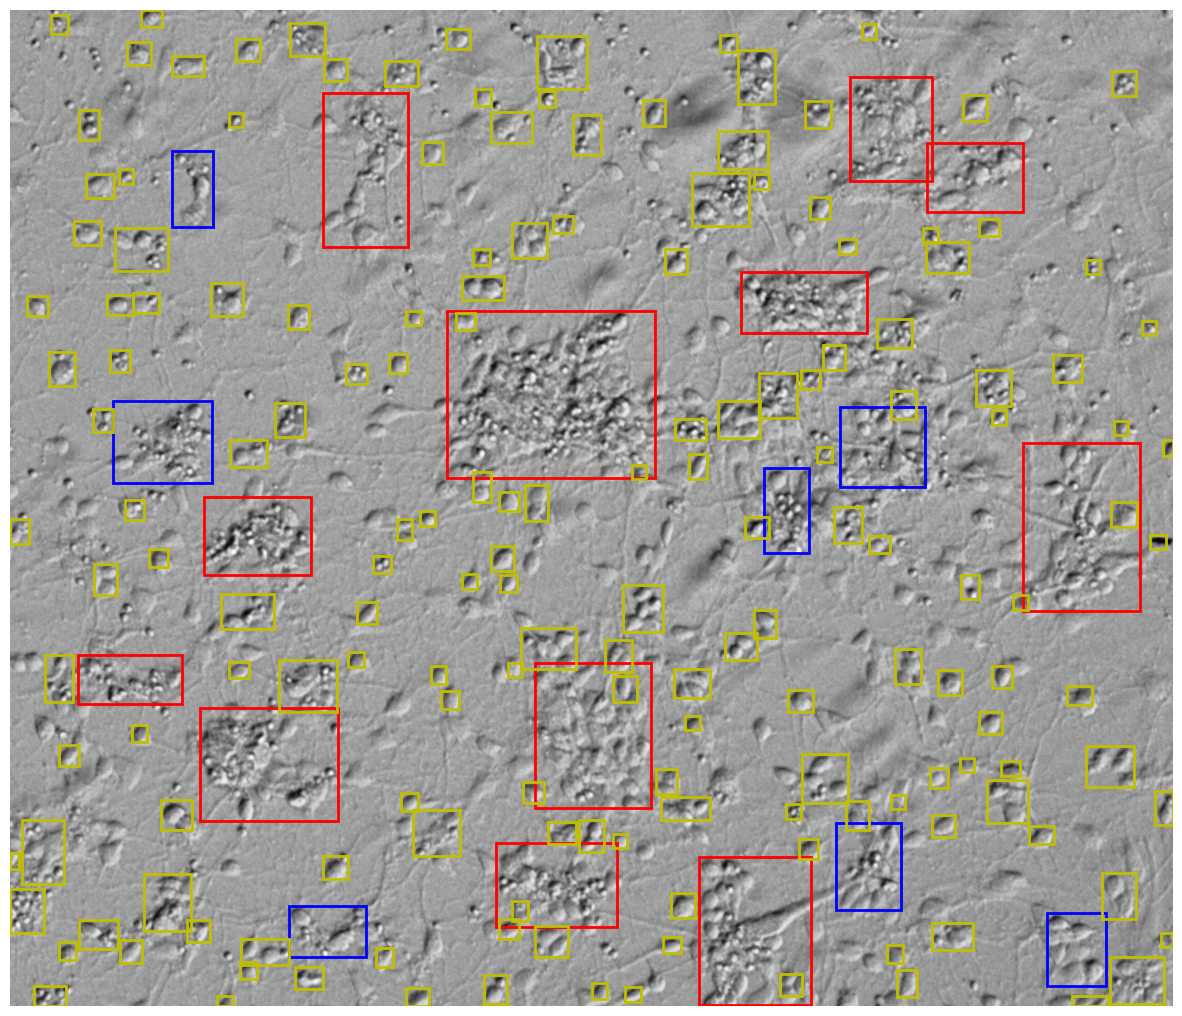

In [123]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_filt*-1, cmap='Greys')

for sphere_region in measure.regionprops(sphere_mask):
    minr, minc, maxr, maxc = sphere_region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='r', linewidth=2)
    ax.add_patch(rect)

for cluster_region in measure.regionprops(cluster_mask):
    minr, minc, maxr, maxc = cluster_region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='b', linewidth=2)
    ax.add_patch(rect)

for cell_region in measure.regionprops(cell_mask):
    minr, minc, maxr, maxc = cell_region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='y', linewidth=2)
    ax.add_patch(rect)

plt.axis('off')
plt.show()

### Resume plot

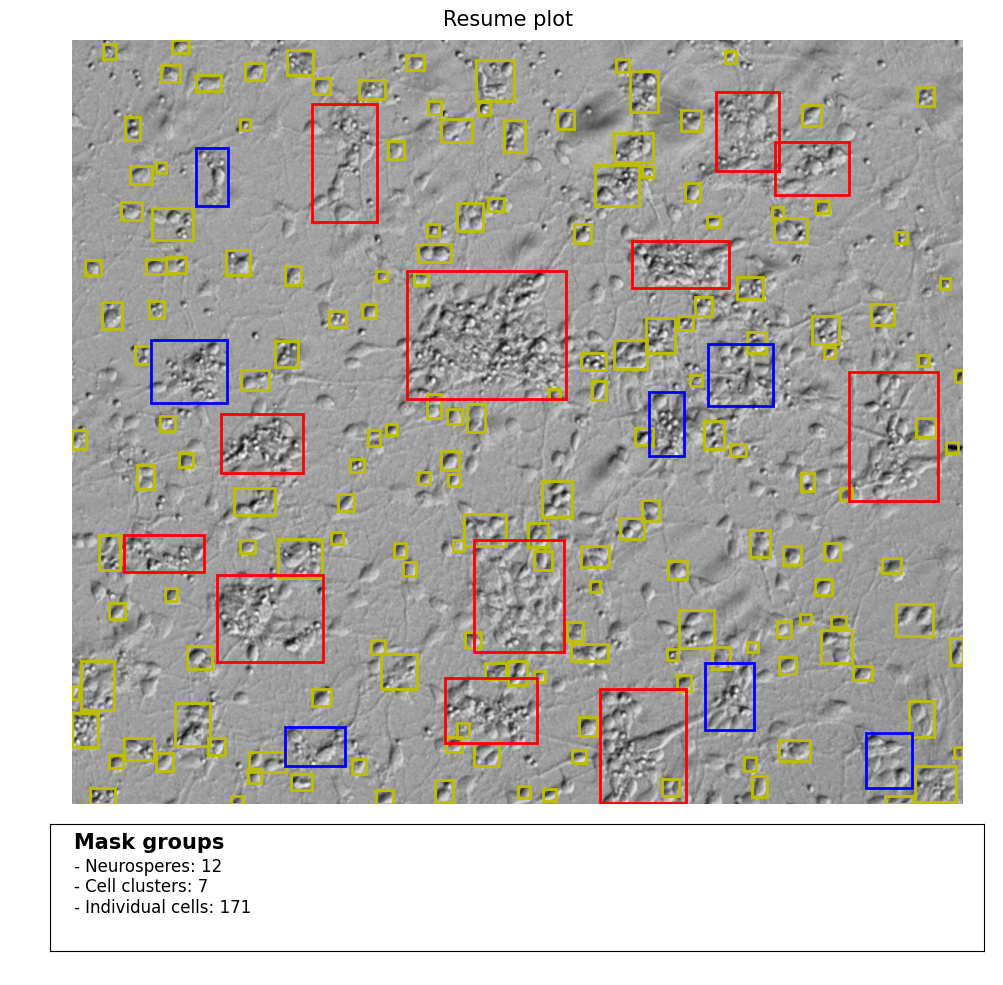

In [124]:
# https://www.geeksforgeeks.org/how-to-create-different-subplot-sizes-in-matplotlib/

spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[6, 1])
fig = plt.figure(figsize=(10,10))
fig.suptitle('Resume plot', fontsize=15)

ax1 = fig.add_subplot(spec[0])
ax1.imshow(img_filt*-1, cmap='Greys')
for cell_region in measure.regionprops(cell_mask):
    minr, minc, maxr, maxc = cell_region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='y', linewidth=2)
    ax1.add_patch(rect)
for cluster_region in measure.regionprops(cluster_mask):
    minr, minc, maxr, maxc = cluster_region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='b', linewidth=2)
    ax1.add_patch(rect)
for sphere_region in measure.regionprops(sphere_mask):
    minr, minc, maxr, maxc = sphere_region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='r', linewidth=2)
    ax1.add_patch(rect)
ax1.axis('off')

ax2 = fig.add_subplot(spec[1])
ax2.axis([0, 10, 0, 10])
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
ax2.text(0.25, 8, 'Mask groups', weight='bold', fontsize=15)
ax2.text(0.25, 3, f'- Neurosperes: {sphere_num}\n- Cell clusters: {cluster_num}\n- Individual cells: {cell_num}', fontsize=12 )

fig.tight_layout()
plt.show()